# Projecting the 12km NCAR AK hydrologic dataset

This notebook steps through deriving the spatial info needed for the AK NCAR hydrologic dataset found here: [21st Century Hydrologic Projections for Alaska and Hawaii](https://www.earthsystemgrid.org/dataset/ucar.ral.hydro.predictions.html), under the "Alaska Near Surface Meteorology Daily Averages" child dataset.

The netCDF files in this dataset have latitude and longitude geogrids, where the longitude values are on the [0, 360) domain.

We will derive a proj string and compute the x and y coordinate values using the following information provided by NCAR about the dataset:

* Projection: Polar Stereographic
* Standard long: 150 W
* True lat: 64 N
* WRF assumes a spherical earth with a radius of 6370 km.

The coordinate values will be backtransformed to validate the new projection info, and then it will be assigned with the new x and y coordinate values to demonstrate actually creating a new file with spatial info that most GIS's should understand.

In [1]:
# open original ncar file
import xarray as xr


# this file on SNAP infra can be found in /workspace/Data/Base_Data/Climate/AK_NCAR_12km/met/GFDL-ESM2M/rcp85/
fp = "data/GFDL-ESM2M_rcp85_BCSD_met_2070.nc4"
gfdl_ds = xr.open_dataset(fp)

Create a proj string for the projection using info provided by NCAR:

In [2]:
from wrf import PolarStereographic


# values provided by NCAR (email correspondence)
wrf_proj_str = PolarStereographic(**{"TRUELAT1": 64, "STAND_LON": -150}).proj4()
print(wrf_proj_str)

+proj=stere +units=m +a=6370000.0 +b=6370000.0 +lat_0=90.0 +lon_0=-150 +lat_ts=64 +nadgrids=@null


Create projected coordinate values for x and y dimensions:

In [3]:
import numpy as np
from pyproj import Proj, Transformer


wrf_proj = Proj(wrf_proj_str)
wgs_proj = Proj(proj='latlong', datum='WGS84')
transformer = Transformer.from_proj(wgs_proj, wrf_proj)
e, n = transformer.transform(-150, 64)
# Grid parameters
dx, dy = 12000, 12000
ny, nx = gfdl_ds.longitude.shape
# Down left corner of the domain
x0 = -(nx-1) / 2. * dx + e
y0 = -(ny-1) / 2. * dy + n
# 2d grid
x = np.arange(nx) * dx + x0
y = np.arange(ny) * dy + y0

Back-transform the new x, y coordinates to WGS84 and compare error as a way to validate the new projection:

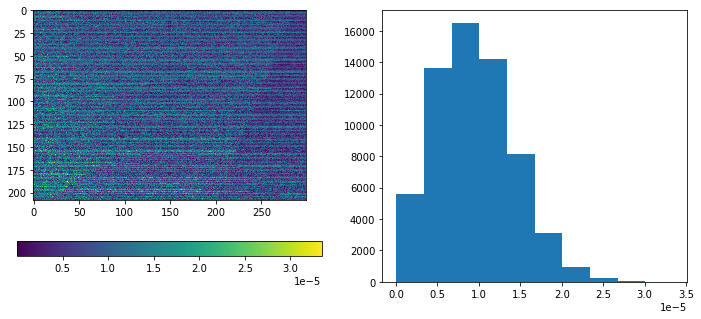

In [4]:
import matplotlib.pyplot as plt


xx, yy = np.meshgrid(x, y)
transformer = Transformer.from_proj(wrf_proj, wgs_proj)
our_lons, our_lats = transformer.transform(xx, yy)
our_lons[our_lons <= 0] = our_lons[our_lons <= 0] + 360
error_arr = np.sqrt((our_lons - gfdl_ds.longitude.values)**2 + (our_lats - gfdl_ds.latitude.values)**2)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
im = axs[0].imshow(error_arr, interpolation="none")
plt.colorbar(im, ax=axs[0], orientation="horizontal")
axs[1].hist(error_arr.flatten())
plt.show()

Great! Let's use this info and demonstrate assigning it to an existing slice of the data.

Assign the projected coordinate values to x and y dimensions on a single time slice (doing a time slice just for simplicty)

In [5]:
new_ds = gfdl_ds["tmin"].sel(time="2070-01-01").assign_coords({"y": ("y", y), "x": ("x", x)})

Assign that to the DataArray:

In [6]:
import rioxarray


new_ds = new_ds.rio.write_crs(wrf_proj_str)
new_ds["spatial_ref"].attrs["crs_wkt"]

'PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6370000,0],EXTENSION["PROJ4_GRIDS","@null"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",64],PARAMETER["central_meridian",-150],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH]]'

In [7]:
new_ds.rio.to_raster("data/GFDL-ESM2M_rcp85_2070-01-01_tmin_georeferenced.nc")